# <center> <font style="color:rgb(100,109,254)">  Feature based Image Alignment </font> </center>

Image Alignment ( also called image registration) is a technique to align different images of the same object/scene, for example consider the below 2 images of a document at different orientations, translations and scales, with image Alignment you can align them back to the original image.

Its called Feature based Image Alignment because it uses Image features to align these images. It warps the image and aligns it in such a way that the features line up properly in the same orientation as were detected in the original. So for e.g the x,y coordinate of a corner of object in one image will be the same in another image after they are aligned.

###  <font style="color:rgb(134,19,348)">  When do we need Image Alignment:  </font>

It has lots of applications mainly in document processing and analysis, So anytime you want to perform OCR (Optical Character Recognition), scan the document (Detect and align it properly). An interesting application of this would be a form reader, which reads input fields of a form so you need to make sure the form is aligned properly first.

Image Alignment is also a really important step in panoramas creation, which we will see later. So its used to create full 360 Degree images. Now 3D alignment does requires depth information but when you're taking pictures by just rotating the camera about its optical axis then those can be aligned using this technique.


The whole process in pretty simple and its almost exactly the same as you did in Object detection.

Here are the steps you'll perform.

- **Step 1:** Extract Keypoints and descriptors of both images, the reference image (Original Aligned Image) and the target Image (The Unaligned image).
- **Step 2:** Perform feature matching, select top few matches.
- **Step 3:** Grab the keypoints of the good matches and get a homography of it.
- **Step 4:** Use the homography to transform the image using **warpPerspective** function. This is your aligned image.

**Note:** Step 1-3 are the same as in our Object Detection Pipeline.

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## <font style="color:rgb(134,19,348)"> Step 1: Feature Extraction   </font>

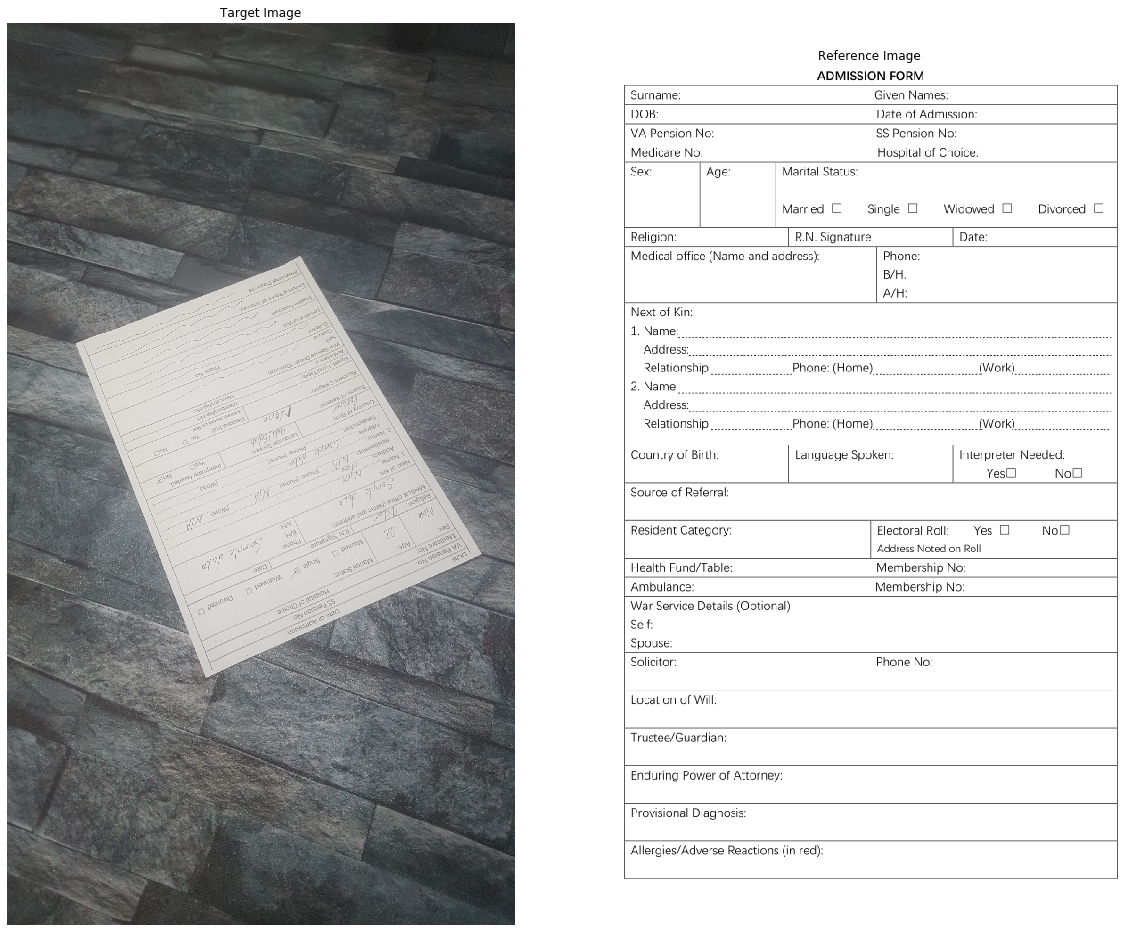

In [58]:
target_image = cv2.imread('media/M4/sample-form.jpg',1) 
reference_image = cv2.imread('media/M4/alignedform.png',1)  

# Initialize ORB detector with features detection limited to 1000 features.
orb = cv2.ORB_create(1000, fastThreshold=30)

# Find the keypoints and descriptors with ORB
kp1, des1 = orb.detectAndCompute(target_image, None)
kp2, des2 = orb.detectAndCompute(reference_image, None)


plt.figure(figsize=[20,20])
plt.subplot(121);plt.imshow(target_image[...,::-1]);plt.title("Target Image");plt.axis('off');
plt.subplot(122);plt.imshow(reference_image[...,::-1]);plt.title("Reference Image");plt.axis('off');

## <font style="color:rgb(134,19,348)"> Step 2: Feature Matching   </font>

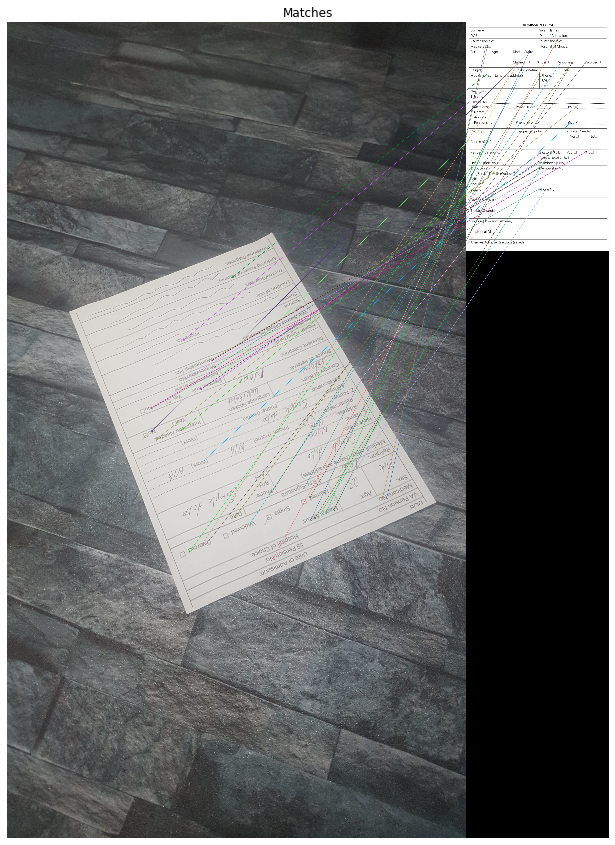

In [52]:
# create bf matcher wiht crosscheck = True
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck = True) 
matches = bf.match(des1, des2) 
  
# Sort matches on bases of good they are, (i.e on their hamming distance)
matches.sort(key = lambda x: x.distance) 
  
# Contols what percent of top matches you want to consider.
match_percent = 0.15    

# Consider the top 25% matches only. 
good_matches = matches[:int(len(matches)*match_percent)] 

# Display the matches just for visulatization.
matches_img = cv2.drawMatches(target_image, kp1, reference_image, kp2, good_matches, None, flags=2)

plt.figure(figsize=[15,15])
plt.imshow(matches_img[...,::-1]);plt.title("Matches");plt.axis('off');

**Note:** You actually need only 4 good matches for actual transformation, so decreasing the percentage would give you good results, sometimes you may not even require RANSAC for good results.

## <font style="color:rgb(134,19,348)">Step 3: Homography    </font>

In [56]:
# Getting the x,y Coordinates of the best matches in the right format.
src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

# Get Homography
homo_matrix, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)   

print("Homograhy matrix \n\n {}".format(homo_matrix))

# Get the height and width of the reference image.
h, w = reference_image.shape[:2]

Homograhy matrix 

 [[-8.26923458e-01  5.05898594e-01  4.17340112e+02]
 [-3.58848421e-01 -8.00112963e-01  2.22440982e+03]
 [ 3.82044859e-05  3.13431516e-04  1.00000000e+00]]


## <font style="color:rgb(134,19,348)">Step 4: Warp the Image    </font>
Now we will use **warpPerspective()** to perform perspective transformation on the image, this is something we have already done in *Geometric transformations Notebook*

[``` dst = cv2.warpPerspective(src, M, dsize[, dst[, flags[, borderMode[, borderValue]]]])```](https://docs.opencv.org/master/da/d54/group__imgproc__transform.html#gaf73673a7e8e18ec6963e3774e6a94b87)

**Params:**

- **`src`**	input image.
- **`dst`**	output image that has the size dsize and the same type as src .
- **`M`**	3×3 transformation matrix.
- **`dsize`**	size of the output image.
- **`flags`**	combination of interpolation methods (INTER_LINEAR or INTER_NEAREST) and the optional flag WARP_INVERSE_MAP, that sets `M` as the inverse transformation ( dst→src ).
- `borderMode`	pixel extrapolation method (BORDER_CONSTANT or BORDER_REPLICATE).
- `borderValue`	value used in case of a constant border; by default, it equals 0.

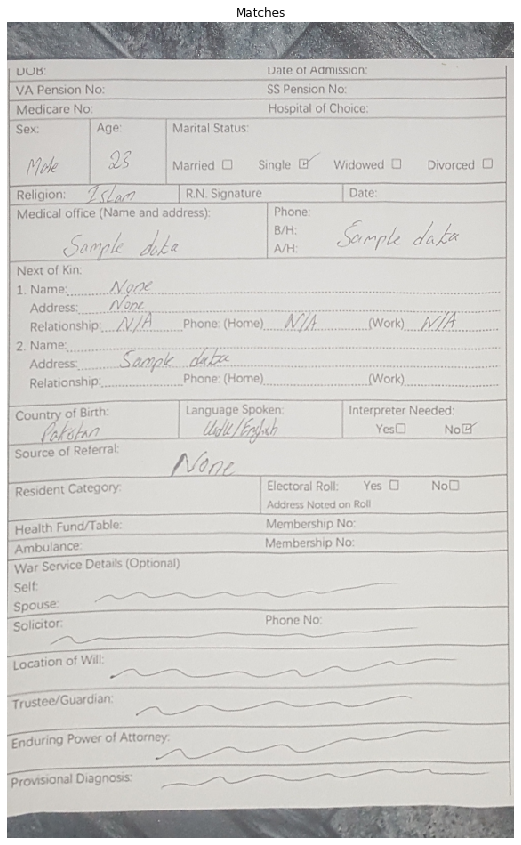

In [57]:
aligned_img = cv2.warpPerspective(target_image, homo_matrix, (w, h))

plt.figure(figsize=[15,15])
plt.imshow(aligned_img[...,::-1]);plt.title("Matches");plt.axis('off');

**Note:** If you're wondering why are there spaces on top and bottom, that's because when I printed this form out, it got clipped from top and bottom, you can look at the original aligned version to confirm this. 